# Import Libraries

In [2]:
!pip install tensorflow==2.9.1

In [3]:
# import system libraries
import os
import PIL
from PIL import Image
import cv2
import itertools

# import Data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet import EfficientNetB3
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Read data and store it in dataframe

In [4]:
# Generate data paths with labels
data_dir = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
filepaths = []
labels = []

folders = os.listdir(data_dir)
for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        filepath = os.path.join(foldpath, file)
        
        filepaths.append(filepath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [5]:
df

,filepaths,labels
0,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
1,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
2,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
3,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
4,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
...,...,...
1120,/kaggle/input/multiclass-weather-dataset/Multi...,Shine
1121,/kaggle/input/multiclass-weather-dataset/Multi...,Shine
1122,/kaggle/input/multiclass-weather-dataset/Multi...,Shine
1123,/kaggle/input/multiclass-weather-dataset/Multi...,Shine


In [6]:
df['labels'].value_counts()

labels
Sunrise    357
Cloudy     300
Shine      253
Rain       215
Name: count, dtype: int64

## Split dataframe into train, valid, and test

In [7]:
# train dataframe
train_df, dummy_df = train_test_split(df, test_size=.2, shuffle=True, random_state=123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df, test_size=.4, shuffle=True, random_state=123)

## Create image data generator

In [8]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


## Show sample from train data

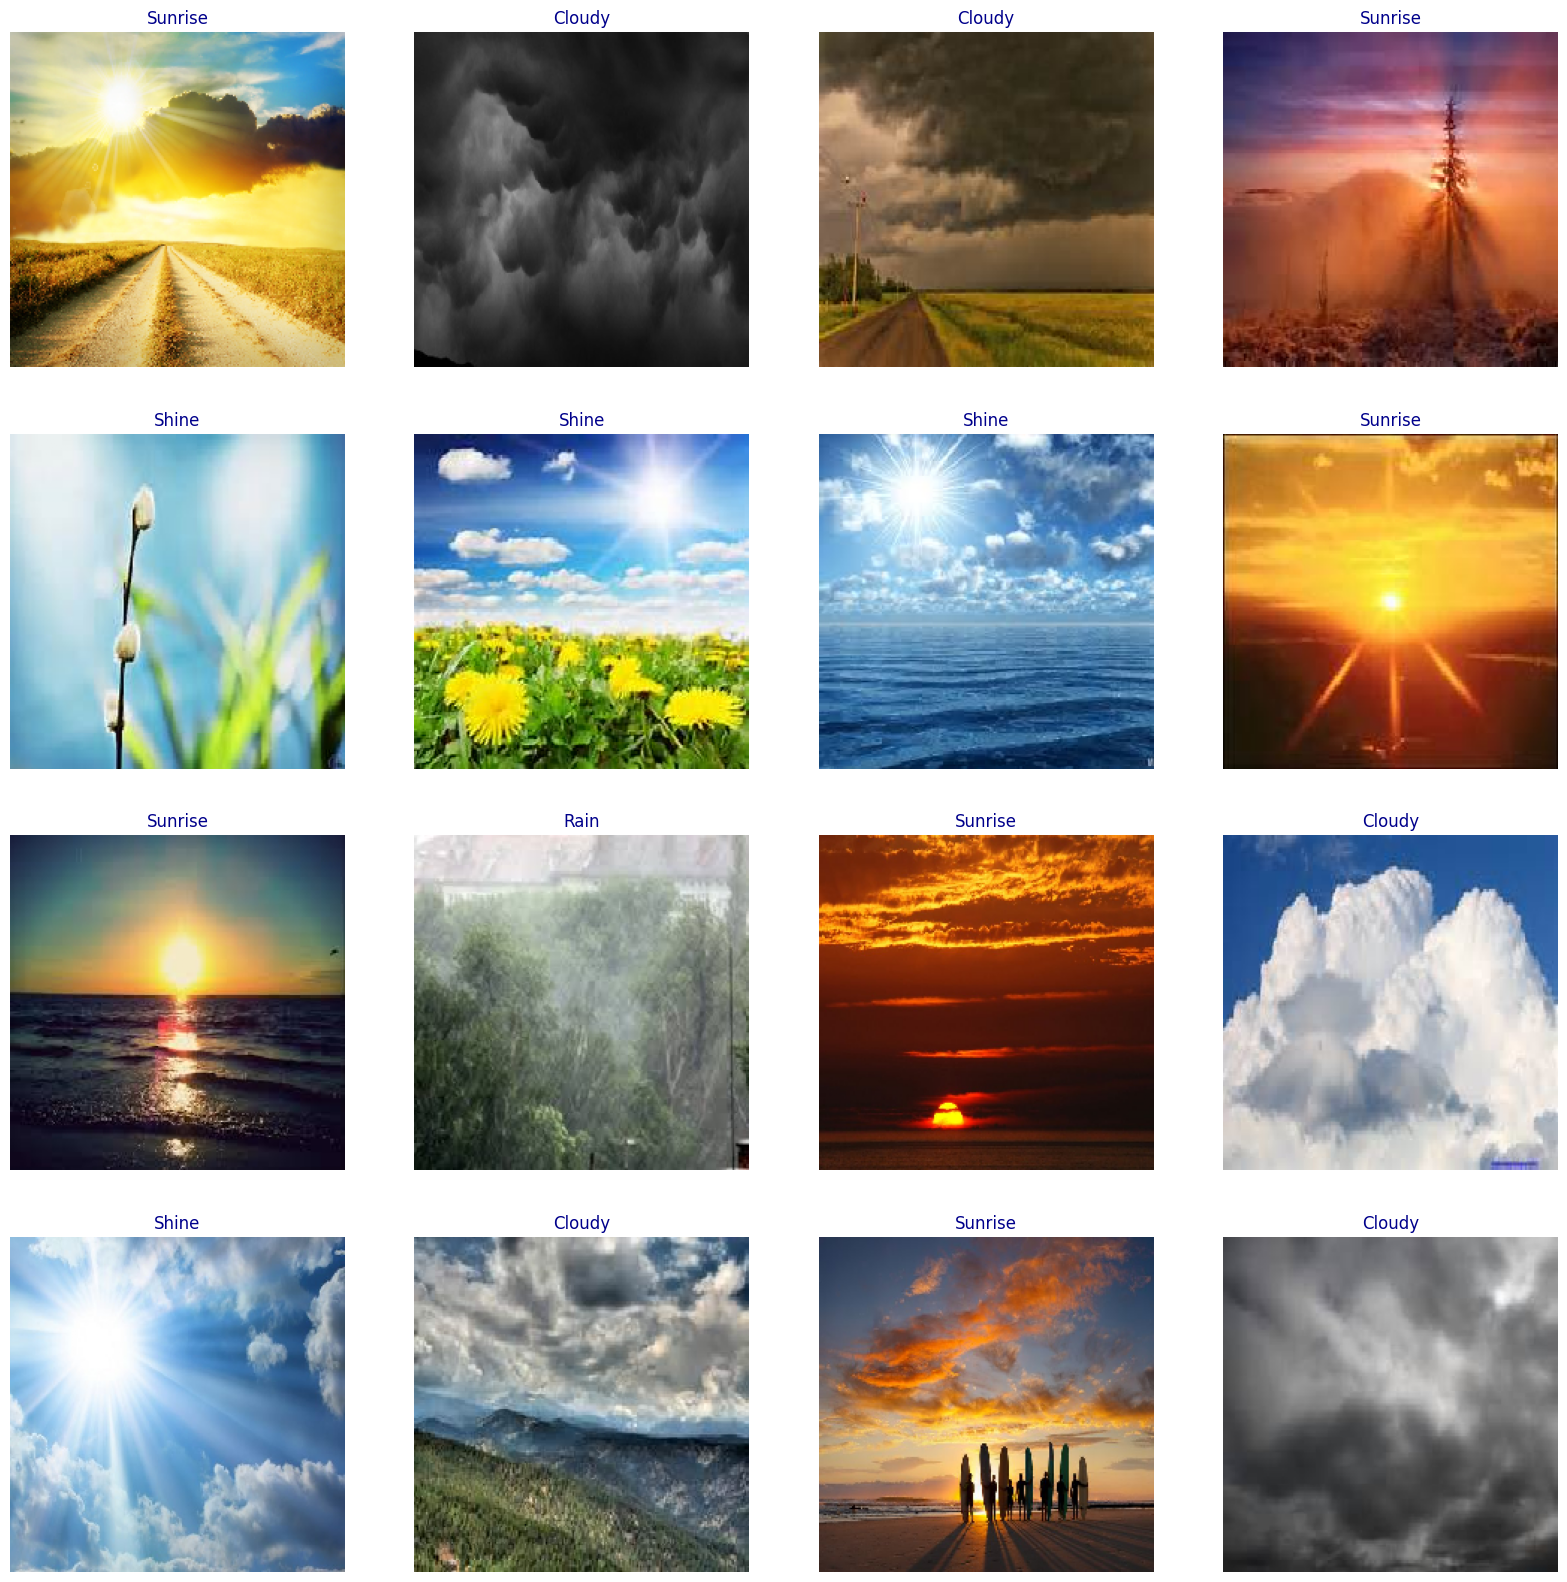

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'darkblue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    Dropout(rate=.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= .0001), loss = 'categorical_crossentropy', 
              metrics=['acc', tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

## Train Model

In [11]:
history = model.fit(train_gen, epochs=30, verbose=1, validation_data=valid_gen, 
                    validation_steps= None, shuffle=False)

Epoch 1/30
57/57 [==============================] - 260s 4s/step - loss: 1.8115 - acc: 0.3733 - precision: 0.3927 - recall: 0.3089 - auc: 0.6406 - val_loss: 1.9328 - val_acc: 0.4444 - val_precision: 0.4602 - val_recall: 0.3852 - val_auc: 0.6535
Epoch 2/30
57/57 [==============================] - 239s 4s/step - loss: 1.0613 - acc: 0.5978 - precision: 0.6392 - recall: 0.5256 - auc: 0.8304 - val_loss: 0.9420 - val_acc: 0.6000 - val_precision: 0.6636 - val_recall: 0.5407 - val_auc: 0.8643
Epoch 3/30
57/57 [==============================] - 239s 4s/step - loss: 0.6970 - acc: 0.7311 - precision: 0.7710 - recall: 0.6844 - auc: 0.9188 - val_loss: 0.5515 - val_acc: 0.7778 - val_precision: 0.8347 - val_recall: 0.7481 - val_auc: 0.9491
Epoch 4/30
57/57 [==============================] - 239s 4s/step - loss: 0.4978 - acc: 0.8100 - precision: 0.8401 - recall: 0.7767 - auc: 0.9572 - val_loss: 0.4355 - val_acc: 0.8593 - val_precision: 0.8750 - val_recall: 0.8296 - val_auc: 0.9667
Epoch 5/30
57/57 [==

## Display model performance

In [13]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
tr_perc = history.history['precision']
tr_recall = history.history['recall']
tr_auc = history.history['auc']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

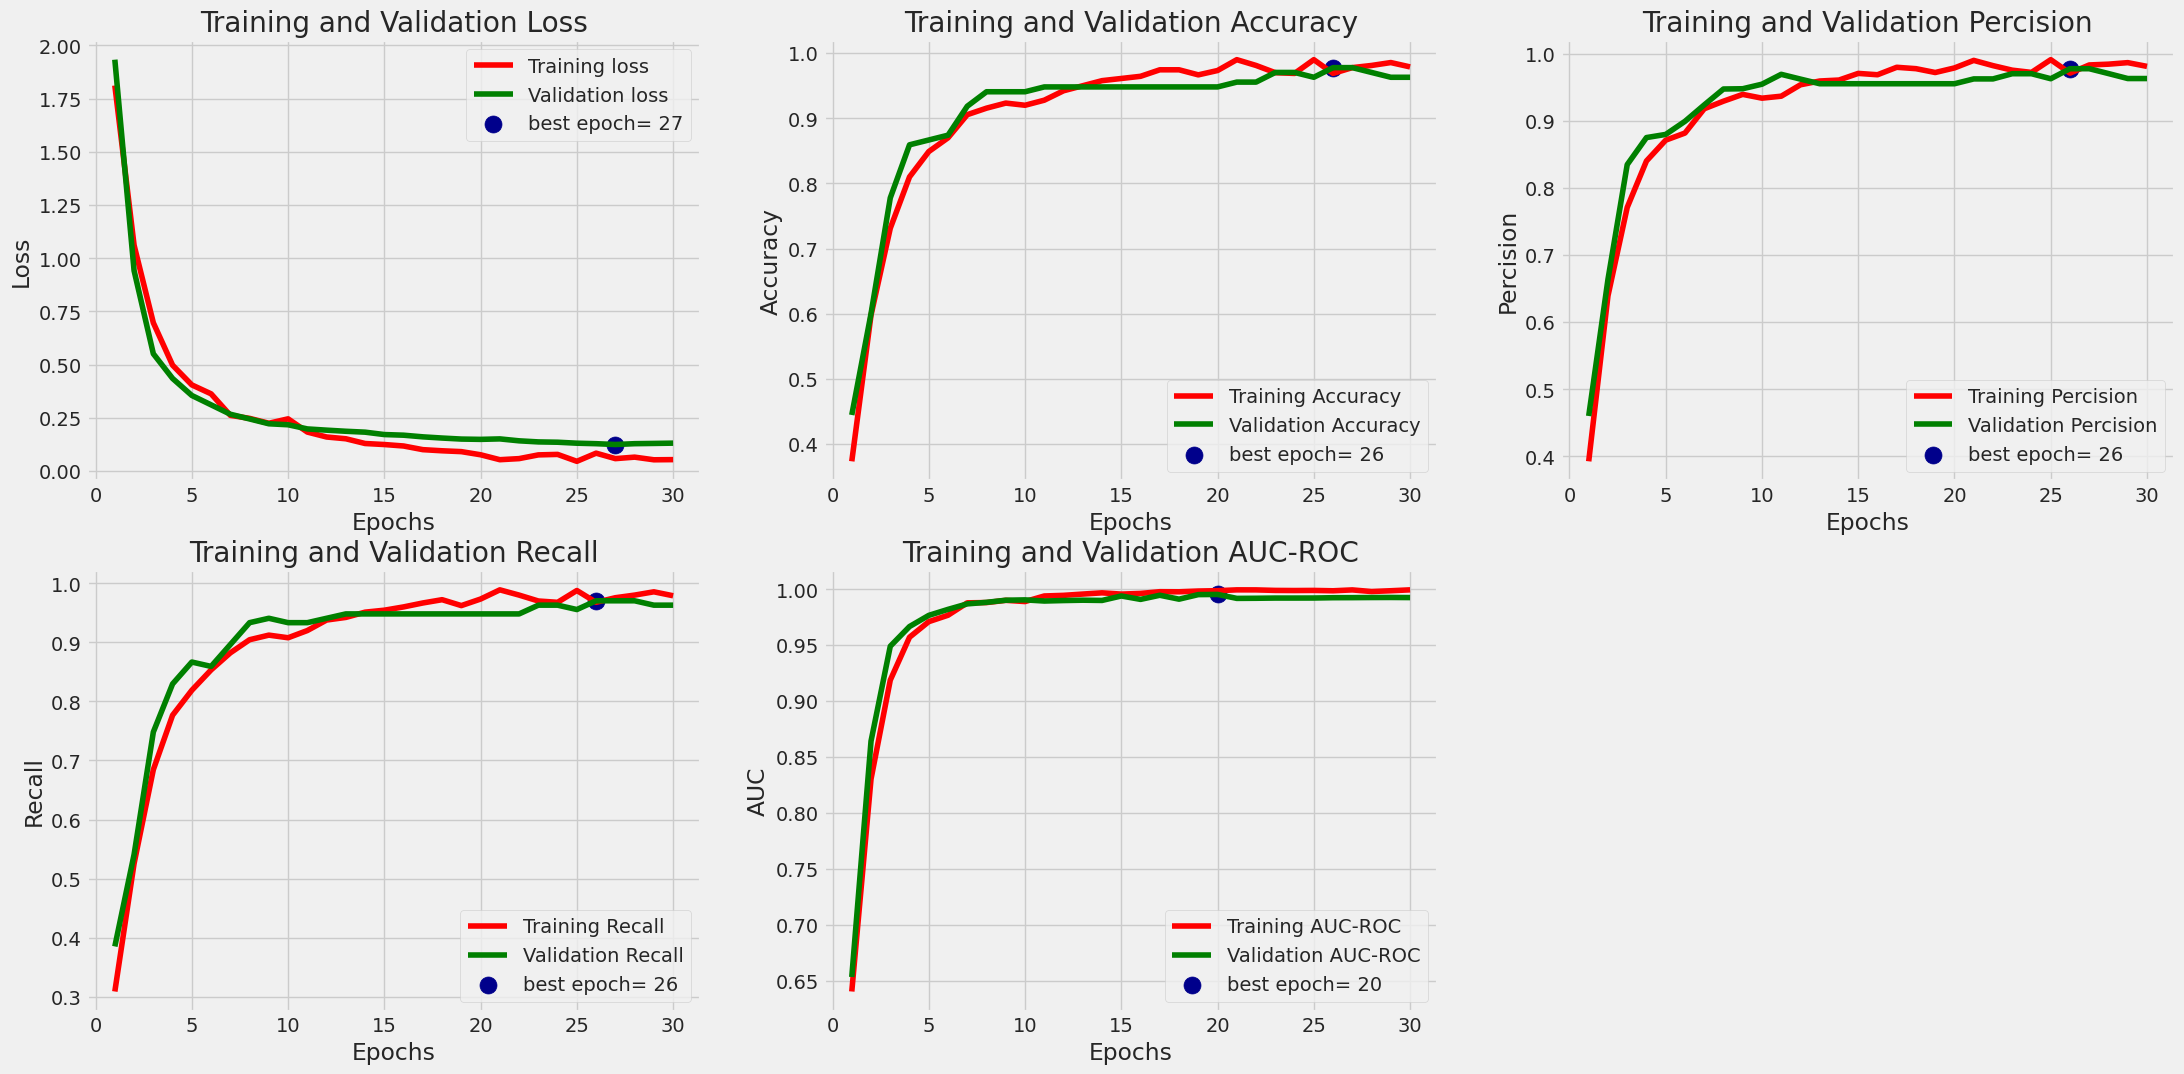

In [25]:
# Plot training history
plt.figure(figsize= (24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label= 'Training Percision')
plt.plot(Epochs, val_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'darkblue', label= perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'darkblue', label= recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label= 'Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC-ROC')
plt.scatter(index_auc + 1 , auc_highest, s= 150, c= 'darkblue', label= auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [26]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

6/6 [==============================] - 5s 790ms/step - loss: 0.1369 - acc: 0.9556 - precision: 0.9663 - recall: 0.9556 - auc: 0.9971
Train Loss:  0.001295470166951418
Train Accuracy:  1.0
--------------------
Validation Loss:  0.1316215991973877
Validation Accuracy:  0.9629629850387573
--------------------
Test Loss:  0.13691259920597076
Test Accuracy:  0.9555555582046509


# Get Predictions

In [27]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

6/6 [==============================] - 7s 770ms/step


## Confusion Matrics and Classification Report

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [29]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[22,  0,  1,  0],
       [ 0, 14,  0,  0],
       [ 1,  0, 21,  1],
       [ 1,  0,  0, 29]])

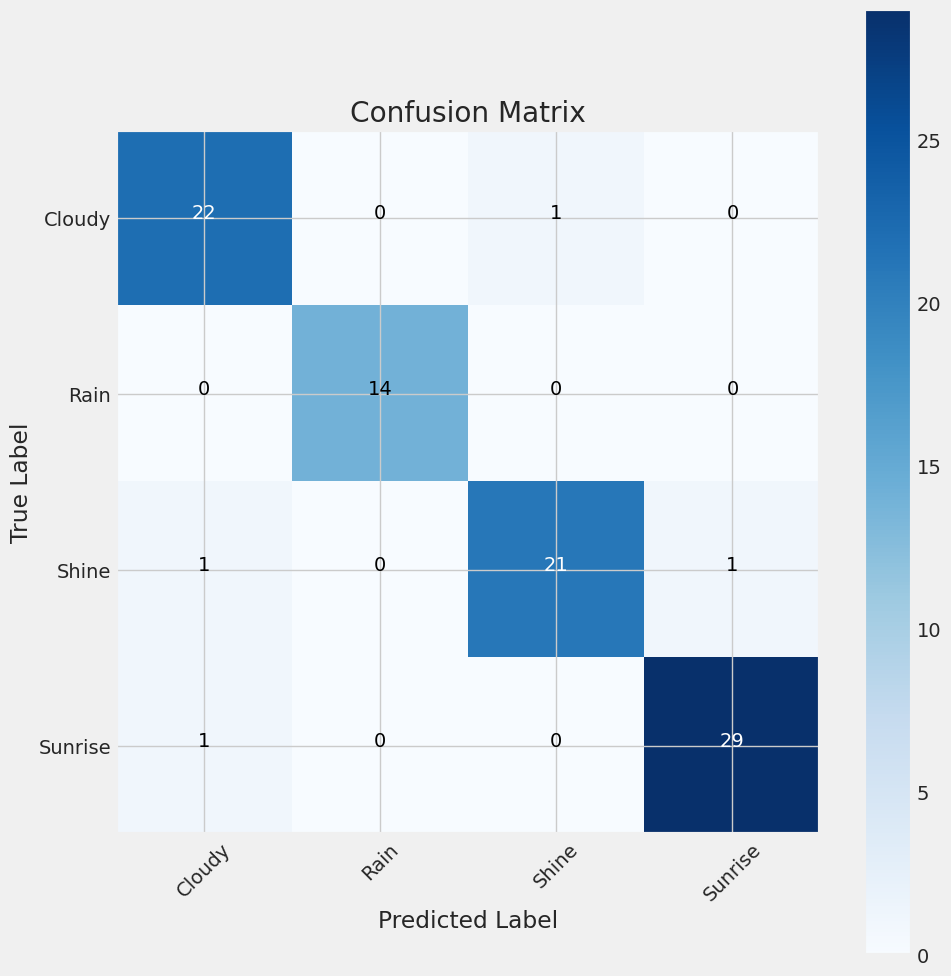

In [31]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [32]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.92      0.96      0.94        23
        Rain       1.00      1.00      1.00        14
       Shine       0.95      0.91      0.93        23
     Sunrise       0.97      0.97      0.97        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



## Save model

In [33]:
#Save the model
model.save('Weather Model.h5')